In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pandas as pd
import ctypes
import numpy as np
from scipy.stats import *
import matplotlib.pyplot as plt
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from numba import njit
# print("here")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
data = pd.read_csv(r"5bundle.csv")
data_25 = pd.read_csv(r"2.5bundle.csv")
times = data["Time (s)"].to_numpy()[:-3]
observed = data_25.iloc[:-3, 1:11].to_numpy().T
# observed

In [3]:
# @njit
def custom_summary_func(data):
    return np.sort(np.mean(data, axis=0))

In [4]:
nstatevars = 2

def gillespie_step(rng, state, time, rate_function, reaction_functions, num_agents=1):
    # get rates
    cumulative_rates = np.cumsum(rate_function(state))
    total_rate = cumulative_rates[-1]

    # calculate timestep
    dt = rng.exponential(1.0 / total_rate)
    new_time = time + dt

    # determine which reaction happened and to which agent
    normalized_rates = cumulative_rates/total_rate
    reaction_index = np.argmax(normalized_rates >= rng.random())

    
    reaction_function = reaction_functions[reaction_index // num_agents]
    reaction_agent = reaction_index % num_agents
    
    # do reaction
    new_state = None
    if num_agents == 1:
        new_state = reaction_function(state)
    else:
        new_state = reaction_function(state, reaction_agent)
    return new_state, new_time

def run_gillespie(rng, initial_state, rate_function, reaction_functions, eval_times, num_agents):
    # run gillespie simulation
    time = 0
    eval_index = 0
    eval_states = np.empty(len(eval_times), dtype=object)
    state = initial_state.copy()
    while eval_index < len(eval_times):
        while eval_index < len(eval_times) and time >= eval_times[eval_index]:
            eval_states[eval_index] = state
            eval_index += 1
        state, time = gillespie_step(rng, state, time, rate_function, reaction_functions)

    return eval_states

def run_sim(rng, theta, times):
    initial_state = np.array([0,0])
    R01, k10, k12, k21 = theta
    def rate_function(state):
        return np.array([
                R01,             # ... + PRC1 -> n1
                k12 * state[0],  # PRC1 + n1 -> n2
                k21 * state[1],  # n2 -> n1 + PRC1
                k10 * state[0]   # n1 -> ... + PRC1
            ]).ravel()
    
    def r1(state):
        return state +  np.array([1, 0])
    
    def r2(state):
        return state + np.array([-1, 1])
    
    def r3(state):
        return state + np.array([1, -1])
    
    def r4(state):
        return state + np.array([-1, 0])
    
    reaction_functions = [r1, r2, r3, r4]
    
    eval_times = times
    num_agents = 1
    
    states = run_gillespie(rng, initial_state, rate_function, reaction_functions, eval_times, num_agents)
    return np.array([state for state in states])


def gillespie_sim(rng, R01, k10, k12, k21, size):
    return np.array([np.sum(run_sim(rng, (R01, k10, k12, k21), times), axis=1) for _ in range(2)])

def mean_and_std(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    p = np.argsort(means)
    return np.concatenate((means[p], stds[p]))

# print(gillespie_sim(np.random.default_rng(12345), 1, 1, 1, 1, 18).shape)

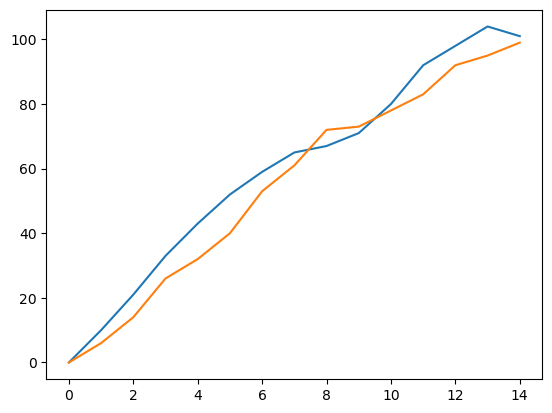

In [5]:
synthetic_data = gillespie_sim(np.random.default_rng(12345), 2.83723976, 3.19827888, 620.3984088, 2.45246624, 5)
plt.plot(synthetic_data[0])
plt.plot(synthetic_data[1])

In [6]:
%%time
run_count = 0
with pm.Model() as example:
    R01 = pm.Exponential("R01", 0.1)
    # R01 = 2.83723976
    k10 = pm.Exponential("k10", 0.1)
    # k10 = 3.19827888
    k12 = pm.TruncatedNormal("k12", mu=800, sigma=400, lower=0)
    # k12 = 1518
    k21 = pm.Exponential("k21", 0.1)
    # k21 = 2.45246624
    # mu = pm.Normal("mu", mu = 0, sigma = 5)
    # sigma = pm.HalfNormal("sigma", sigma=1)

    s = pm.Simulator("s", gillespie_sim, params=(R01, k10, k12, k21), sum_stat=mean_and_std, epsilon=10, observed=observed)
    # s = pm.Simulator("s", sim, params=(mu, sigma), sum_stat=mean_and_std, epsilon=0.1, observed=data)

    idata = pm.sample_smc(draws=10, cores=1)
    # idata.extend(pm.sample_posterior_predictive(idata))

Initializing SMC sampler...
Sampling 2 chains in 1 job


Output()

The number of samples is too small to check convergence reliably.


CPU times: total: 11.7 s
Wall time: 5min 31s


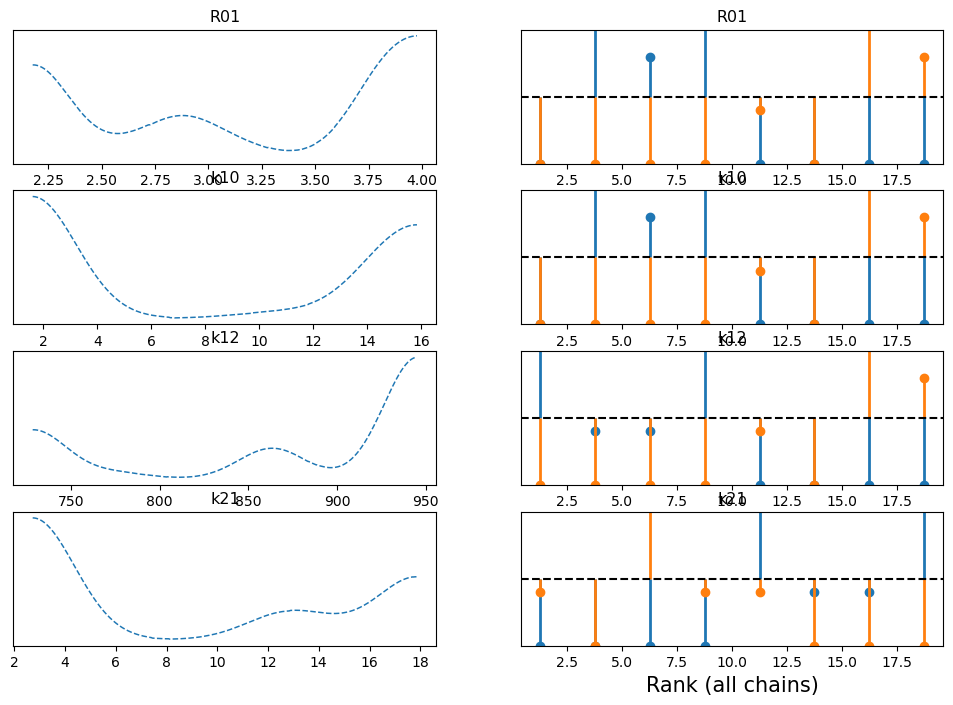

In [8]:
az.plot_trace(idata, combined=True, kind="rank_vlines");

In [9]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
R01,3.139,0.718,2.175,3.917
k10,8.129,6.685,1.594,15.445
k12,871.952,86.498,728.266,943.845
k21,9.242,6.628,3.044,17.885


In [10]:
posterior = idata["posterior"]

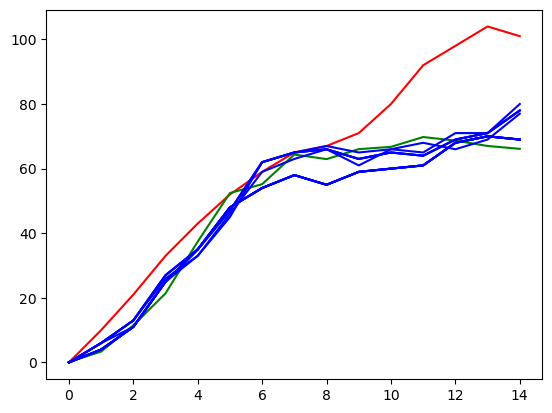

In [11]:
plt.plot(synthetic_data[0], color="red")
plt.plot(np.mean(observed, axis=0), color="green")
for i in range(posterior["k21"][0].size):
    plt.plot(gillespie_sim(np.random.default_rng(42), 2.83723976, posterior["k10"][0][i], posterior["k12"][0][i], posterior["k21"][0][i], 2)[0], color="blue")

In [12]:
# az.plot_ppc(idata, num_pp_samples=500);

In [14]:
!git config --global user.name "KhangBui02"
!git config --global user.email "khangduybui14@gmail.com"

In [15]:
!git clone https://github.com/AdrianHou2/prc-recruitment-bayesian-analysis.git

fatal: destination path 'prc-recruitment-bayesian-analysis' already exists and is not an empty directory.


In [16]:
%cd prc-recruitment-bayesian-analysis

C:\Users\putin\Downloads\prc-recruitment-bayesian-analysis


In [18]:
gillespie_lib = ctypes.CDLL("./gillespielibrary.dll", winmode=0)
gillespie_lib.run_prc1_sim.argtypes = [ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double,
                                       ctypes.POINTER(ctypes.c_double), ctypes.c_int]
gillespie_lib.run_prc1_sim.restype = ctypes.POINTER(ctypes.c_double)

In [27]:
times = np.linspace(0, 80)

def simulate(theta):
    R01, k10, k12, k21 = theta
    num_times = len(times)
    times_array = (ctypes.c_double * num_times)(*times)
    answer_array = gillespie_lib.run_prc1_sim(R01, k12, k10, k21, times_array, num_times)
    # answer_array = gillespie_lib.run_prc1_sim(ctypes.c_double(R01), ctypes.c_double(k12), ctypes.c_double(k10), ctypes.c_double(k21),
                                              # times_array, ctypes.c_int(num_times))
    return answer_array[:num_times]

#simulate((2.83723976, 3.19827888, 620.3984088, 2.45246624))

In [25]:
def prior_density(theta):
    R01, k10, k12, k21 = theta
    p1 = expon.logpdf(R01, scale=10)  # rate = 0.1
    p2 = expon.logpdf(k10, scale=10)
    p3 = truncnorm.logpdf(k12, a=(0-800)/400, b=np.inf, loc=800, scale=400) 
    p4 = expon.logpdf(k21, scale=10)
    return np.exp(p1 + p2 + p3 + p4)

def kernel_density(x, mean, cov):
    return multivariate_normal.pdf(x, mean=mean, cov=cov)
    
def sequential_abc(obs_data,num_generations=4, num_particles=100, sample_size=300):
    epsilon_0, particles, weights, distances = pilot_run(
        sample_size=sample_size,
        num_particles=num_particles,
        obs_data=obs_data
    )
    epsilon_list = [epsilon_0]
    obs_mean = np.mean(obs_data[:, 0])  # means column
    obs_sd   = np.mean(obs_data[:, 1])  # sds column
    obs_summary = np.array([obs_mean, obs_sd])

    kernel_cov = np.cov(particles.T) + 1e-5 * np.eye(particles.shape[1])  # regularization, we need this just for the weight function 

    for t in range(1, num_generations):
        epsilon_t = np.percentile(distances, 50)  #new threshold, currently setting at median
        epsilon_list.append(epsilon_t)

        new_particles, new_weights, new_distances = [], [], []
        while len(new_particles) < num_particles:
            idx = np.random.choice(len(particles), p=weights)
            theta_prev = particles[idx]

            theta_prop = theta_prev + np.random.multivariate_normal(np.zeros(len(theta_prev)), kernel_cov)

            #simulate with proposed theta
            sim_data1 = np.array(simulate(theta_prop))
            sim_mean1 = np.mean(sim_data1)
            sim_sd1 = np.std(sim_data1)
            sim_summary1 = np.array([sim_mean1, sim_sd1])

            d = np.linalg.norm(sim_summary1 - obs_summary)

            if d <= epsilon_t:
                prior_val = prior_density(theta_prop)

                denom = 0.0
                for j in range(len(particles)):
                    denom += weights[j] * kernel_density(theta_prop, mean=particles[j], cov=kernel_cov)
                    #from the paper 

                weight = prior_val / denom
                new_particles.append(theta_prop)
                new_weights.append(weight)
                new_distances.append(d)


        new_weights = np.array(new_weights)
        new_weights /= np.sum(new_weights)
        particles = np.array(new_particles)
        weights = new_weights
        distances = np.array(new_distances)

    return particles, weights, epsilon_list

In [21]:
def sample_theta():
    R01 = pm.Exponential.dist(0.1).eval()
    k10 = pm.Exponential.dist(0.1).eval()
    k12 = pm.TruncatedNormal.dist(mu=800, sigma=400, lower=0).eval()
    k21 = pm.Exponential.dist(0.1).eval()
    return np.array([R01, k10, k12, k21])
    
def pilot_run(sample_size, num_particles, obs_data):
    distances_all = []
    simulated = []
    obs_mean = np.mean(obs_data[:, 0])
    obs_sd   = np.mean(obs_data[:, 1])
    obs_summary = np.array([obs_mean, obs_sd])
    for _ in range(sample_size):
        theta = sample_theta()
        sim_data = np.array(simulate(theta))  
        sim_mean = np.mean(sim_data)
        sim_sd = np.std(sim_data)
        sim_summary = np.array([sim_mean, sim_sd])

        d = np.linalg.norm(sim_summary - obs_summary)
        distances_all.append(d)
        simulated.append((theta, d))
    
    distances_all = np.array(distances_all)
    epsilon_0 = np.percentile(distances_all, 75)

    #select particles 
    accepted = [(theta, d) for theta, d in simulated if d <= epsilon_0]

    #truncate to select up to num_particles
    accepted = accepted[:num_particles]
    accepted_particles = np.array([theta for theta, _ in accepted])
    accepted_distances = np.array([d for _, d in accepted])
    weights = np.ones(len(accepted_particles)) / len(accepted_particles)

    return epsilon_0, accepted_particles, weights, accepted_distances

In [ ]:
final_particles, final_weights, epsilons = sequential_abc(observed)